# Part 2 (A7) - Implement Research Plan

Taso Kinnas

Carry out your proposed research! At the end of this, submit:

* A 5–10 page report with your research questions and results. This should be organized to communicate, without attention to the order in which things need to be run.

* An HTML export of your Jupyter notebook that contains the actual analysis. All figures from your report should appear in this document, in their appropriate computational context.

Notes:  
consider k-means for clustering...
Pearson correlation


 look at
 - splitting out multiple notebooks
 - swap memory (op sys takes care of)
 - write csv and save() and load() for data management with R

 consider consolidatung categories(5-10)
 contour plot (discount, length of time, consider looking at percrnt change in price), ggplot (see Dr. E example on rat tumor)
 heat map

In [1]:
library(tidyverse) # general tidyverse functions

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# sets plot height to 3.5 inches
options(repr.plot.height=3.5)

In [3]:
# function to export plots
make.plot = function(name, plot_expr, type="pdf", width, height, ...) {
    dir.create("data/wholefoods/images", recursive = TRUE, showWarnings = FALSE)
    if (identical(type, "pdf")) {
        pdf(sprintf("data/wholefoods/images/%s.pdf", name),
            width=width, height=height, ...)
    } else if (identical(type, "png")) {
        png(sprintf("data/wholefoods/images/%s.png", name),
            width=width, height=height, units="in", res=300, ...)
    } else {
        stop("invalid plot type")
    }
    print(plot_expr)
    dev.off()
    plot_expr
}

## 1. Project goals:

The company I work for, Impact Group, LLC, is a retail brokerge firm specializing in consumer packaged goods(grocery). We help food manufactuers sell products via grocery stores. The goal of this project is to see if insights can be gained to better market the products of the clients we represent.  Examples include identifying when to promote a certain product, how long to promote it, or if there are complimentary products to promote to boost overall sales to name a few. 

## 2. Data Source:
<b>Please Note:</b> The data is proprietary to Impact Group, LLC and provided for use solely for the purposes of this project.

Our dataset in its entirety is about twelve terabytes in total.  While I think it would be interesting to explore it in it's entirety, for the purposes of this assignment I filtered on a more manageable size to quickly process the data and provide a data source that could be sent to the professor in a practical manner.

As such, this is filtered on sales data of the brands that we represent in Whole Foods Market.  Further, it is filtered on the Pacific Northwest region(Washington, Oregon, and Idaho).  The records include attributes for store, zip code, date, current year sales & units sold, prior years sales & units sold, UPC, product description, brand and category. (I need to re-pull a dataset that includes the category and I will dig a little deeper to see if there are other features to potentially include other features that could answer questions, like utilizing address data with census data for incomes, etc.). 

In [4]:
# read data file, convert columns to relevant data types
# all data (can't use file as zipped...)
#wfm = read_tsv('data/wholefoods/wfm_final.tsv', col_types="cccccccDddddcccc")
# filtered on region 7 (pacific northwest)
wfm = read_tsv('data/wholefoods/wfm_r7.zip', col_types="cccccccDddddcccc")
spec(wfm)
head(wfm)

cols(
  Region = col_character(),
  CustNum = col_character(),
  Store = col_character(),
  Address = col_character(),
  City = col_character(),
  StateAbr = col_character(),
  zip = col_character(),
  Date = col_date(format = ""),
  Sales = col_double(),
  SalesLy = col_double(),
  Units = col_double(),
  UnitsLy = col_double(),
  Brand = col_character(),
  Category = col_character(),
  UPC = col_character(),
  Description = col_character()
)

Region,CustNum,Store,Address,City,StateAbr,zip,Date,Sales,SalesLy,Units,UnitsLy,Brand,Category,UPC,Description
Pacific Northwest,10407,Bend,2610 Highway 2,Bend,OR,97701,2016-01-04,1.79,7.96,1,4,Lotus Foods,Ramen,70895360103,Rice Ramen Millet And Brown Og (2.8oz)
Pacific Northwest,10407,Bend,2610 Highway 2,Bend,OR,97701,2016-01-04,65.89,23.96,11,4,Purely Elizabeth,Granola,85514000216,Granola Blueberry Hemp (12oz)
Pacific Northwest,10407,Bend,2610 Highway 2,Bend,OR,97701,2016-01-04,17.37,0.00,3,0,Purely Elizabeth,Muesli,85514000246,Muesli Mango Almond (10oz)
Pacific Northwest,10407,Bend,2610 Highway 2,Bend,OR,97701,2016-01-04,5.99,5.99,1,1,Lotus Foods,Ramen 4 Pack,70895360202,Rice Ramen Jade Pearl Og 4 Pck (10oz)
Pacific Northwest,10407,Bend,2610 Highway 2,Bend,OR,97701,2016-01-04,11.14,0.00,6,0,Lotus Foods,Ramen,70895360104,Rice Ramen Purple Potato Brown Rice (2.8oz)
Pacific Northwest,10407,Bend,2610 Highway 2,Bend,OR,97701,2016-01-04,18.00,11.56,6,4,Lotus Foods,Rice Bowl,70895350498,Rice Bowl Brown Jasmine Og (7.4oz)


## 3. Data Summary:

In [5]:
summary(wfm)

    Region            CustNum             Store             Address         
 Length:987295      Length:987295      Length:987295      Length:987295     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     City             StateAbr             zip                 Date           
 Length:987295      Length:987295      Length:987295      Min.   :2016-01-04  
 Class :character   Class :character   Class :character   1st Qu.:2016-04-04  
 Mode  :character   Mode  :character   Mode  :character   Median :2016-07-04  
                                                          Mean   :2016-07-03  
                                                          3rd Qu.:

In [6]:
# Rank Stores(Cust Num)
wfm_sales_by_store = wfm %>%
    filter(CustNum != 10564) %>% #Store 10564 appears to be a 'test' store of some sort.
    group_by(CustNum) %>%
    summarize(salesTY=sum(Sales)) %>%
    arrange(-salesTY) %>%
    mutate(s_rank=row_number())
tail(wfm_sales_by_store,1)


# for loop example
testloop = vector("character", length(wfm_sales_by_store$CustNum))
for (i in seq_along(wfm_sales_by_store$CustNum)) {            # 2. sequence
  testloop[[i]] <- wfm_sales_by_store$CustNum[[i]]      # 3. body
}
testloop

CustNum,salesTY,s_rank
10294,171633.9,18


[1] "10153" "10103" "10216" "10275" "10260" "10436" "10266" "10148" "10407"
[10] "10243" "10375" "10588" "10327" "10402" "10412" "10537" "10637" "10294"

In [7]:
# Rank brands, showing last one to see number of brands 
wfm_sales_by_brand = wfm %>%   
    filter(CustNum != 10564) %>% #Store 10564 appears to be a 'test' store of some sort.
    group_by(Brand) %>%
    summarize(salesTY=sum(Sales)) %>%
    arrange(-salesTY) %>%
    mutate(b_rank=row_number())
tail(wfm_sales_by_brand,1)

Brand,salesTY,b_rank
Edward & Sons,0,49


In [8]:
# Rank Category, showing last one to see number of categories
wfm_sales_by_category = wfm %>%
    filter(CustNum != 10564) %>% #Store 10564 appears to be a 'test' store of some sort.
    group_by(Category) %>%
    summarize(salesTY=sum(Sales)) %>%
    arrange(-salesTY) %>%
    mutate(c_rank=row_number())
tail(wfm_sales_by_category,1)

Category,salesTY,c_rank
Youth Blemish Control,0,250


In [9]:
# Rank UPC, showing last one to see number of products we represent for Whole Foods 
wfm_sales_by_upc = wfm %>%
    filter(CustNum != 10564) %>% #Store 10564 appears to be a 'test' store of some sort.
    group_by(UPC) %>%
    summarize(salesTY=sum(Sales)) %>%
    arrange(-salesTY) %>%
    mutate(u_rank=row_number())
tail(wfm_sales_by_upc,1)

UPC,salesTY,u_rank
39978043221,-27.96,2214


In [10]:
# Join with Brand (for some graphing later)
wfm_product_in_brand = wfm %>%
    group_by(UPC, Description, Brand) %>%
    summarize(salesTY=sum(Sales)) %>%
    select(UPC, Description, Brand) %>%
    inner_join(wfm_sales_by_upc)
tail(wfm_product_in_brand,1)

Joining, by = "UPC"


UPC,Description,Brand,salesTY,u_rank
9931,Rice Black Forbidden Og (1lb),Lotus Foods,21114.89,172


# Brand Graphs

In [11]:
# get sales and units totals by week for each brand
wfm_sales_date_brand = wfm %>%     
    group_by(Date, Brand) %>%
    summarize(salesTY=sum(Sales), unitsTY=sum(Units), salesLY=sum(SalesLy), unitsLY=sum(UnitsLy))
head(wfm_sales_date_brand)

Date,Brand,salesTY,unitsTY,salesLY,unitsLY
2016-01-04,Alter Eco,9031.39,2835.10,9696.52,2474.09
2016-01-04,Amazing Grass,15869.52,1506.00,9648.30,1225.00
2016-01-04,Amy's,48381.84,11526.00,41524.22,10090.00
2016-01-04,Barkthins,1060.91,210.00,0.00,0.00
2016-01-04,Blue Diamond,5558.13,1865.00,6165.30,2242.00
2016-01-04,Bob's Red Mill,24621.83,4425.82,24859.38,4485.46


In [12]:
# calculate sales per unit for top 5 brands
top_5_brands = wfm_sales_by_brand %>%
    select(Brand, b_rank) %>%
    inner_join(wfm_sales_date_brand) %>%
    mutate(CpU =salesTY/unitsTY) %>%
    filter(b_rank<=5)
head(top_5_brands)

Joining, by = "Brand"


Brand,b_rank,Date,salesTY,unitsTY,salesLY,unitsLY,CpU
Amy's,1,2016-01-04,48381.84,11526,41524.22,10090,4.197626
Amy's,1,2016-01-11,41204.81,9514,34735.04,8278,4.330966
Amy's,1,2016-01-18,38572.01,8892,36784.73,8667,4.337833
Amy's,1,2016-01-25,44105.28,9949,44782.33,11332,4.433137
Amy's,1,2016-02-01,47166.87,10735,47842.48,12315,4.393747
Amy's,1,2016-02-08,41315.72,9474,36162.97,8759,4.360958


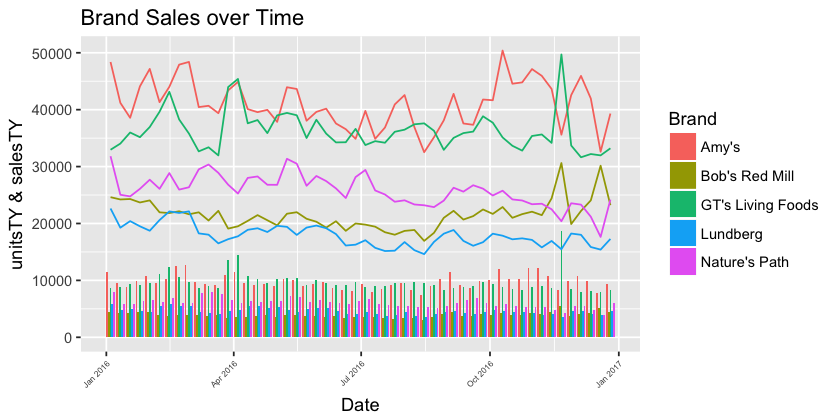

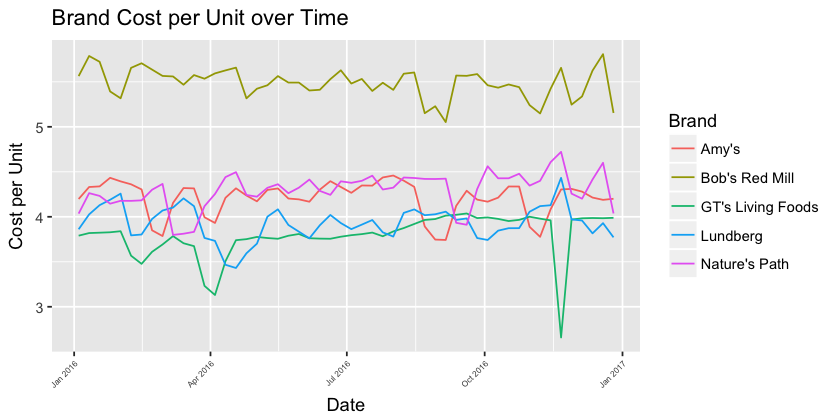

In [13]:
# plot of sales and units for top 5 brands
fancyplot_brand = ggplot(top_5_brands, aes(x=Date, y=unitsTY, fill=Brand)) +
    geom_bar(stat="identity", position="dodge") +
    geom_line(aes(x=Date, y=salesTY, color=Brand)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1)) +
    labs(title="Brand Sales over Time", y="unitsTY & salesTY")

# plot of cost per unit for top 5 brands
cpuplot_brand = ggplot(top_5_brands, aes(x=Date, y=CpU, color=Brand)) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1)) +
    labs(title="Brand Cost per Unit over Time", y="Cost per Unit")
fancyplot_brand
cpuplot_brand
# make.plot("fplot", fancyplot_brand)
# make.plot("fplot2",cpuplot_brand)

# Category Graph

In [14]:
# get sales and units totals by week for each brand
wfm_sales_date_category = wfm %>%     
    group_by(Date, Category) %>%
    summarize(salesTY=sum(Sales), unitsTY=sum(Units), salesLY=sum(SalesLy), unitsLY=sum(UnitsLy))
head(wfm_sales_date_category)

Date,Category,salesTY,unitsTY,salesLY,unitsLY
2016-01-04,10g Protein Bars,1550.79,850,1380.50,670
2016-01-04,10g Protein Bars - LE,37.80,20,64.82,47
2016-01-04,13g Protein Bars,712.13,287,850.09,391
2016-01-04,16oz Pasta,1130.49,331,2210.28,652
2016-01-04,1lb Pasta,881.79,221,969.54,286
2016-01-04,20g Protein Bars,4600.75,1556,6707.29,2810


In [15]:
# calculate sales per unit for top 5 brands
top_5_category = wfm_sales_by_category %>%
    select(Category, c_rank) %>%
    inner_join(wfm_sales_date_category) %>%
    mutate(CpU = salesTY/unitsTY) %>%
    filter(c_rank<=5)
head(top_5_category)

Joining, by = "Category"


Category,c_rank,Date,salesTY,unitsTY,salesLY,unitsLY,CpU
Enlightened,1,2016-01-04,15156.02,4026,14381.64,3816,3.764536
Enlightened,1,2016-01-11,15219.63,4020,15843.92,4148,3.785978
Enlightened,1,2016-01-18,16494.89,4347,15529.27,4071,3.794546
Enlightened,1,2016-01-25,15608.66,4112,17457.60,5086,3.795880
Enlightened,1,2016-02-01,16365.87,4322,19183.31,5799,3.786643
Enlightened,1,2016-02-08,19212.69,5620,14277.24,3911,3.418628


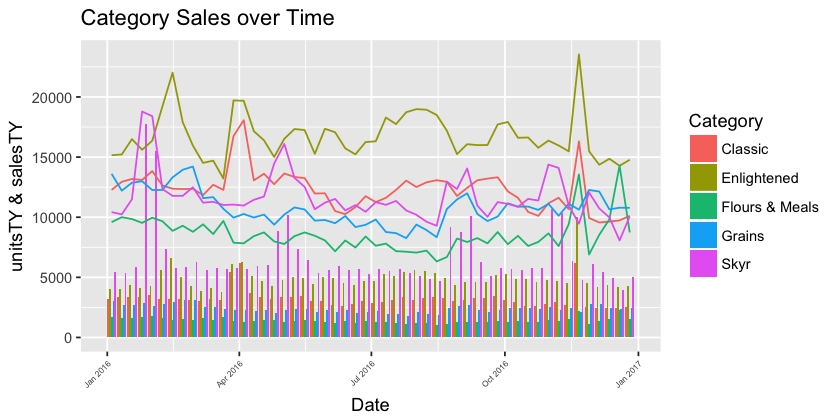

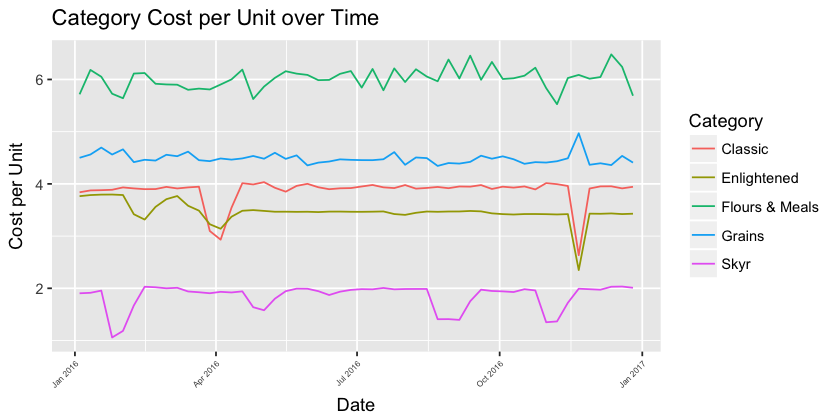

In [16]:
# plot of sales and units for top 5 brands
fancyplot_category = ggplot(top_5_category, aes(x=Date, y=unitsTY, fill=Category)) +
    geom_bar(stat="identity", position="dodge") +
    geom_line(aes(x=Date, y=salesTY, color=Category)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1)) +
    labs(title="Category Sales over Time", y="unitsTY & salesTY")

# plot of cost per unit for top 5 brands
cpuplot_category = ggplot(top_5_category, aes(x=Date, y=CpU, color=Category)) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1)) +
    labs(title="Category Cost per Unit over Time", y="Cost per Unit")
fancyplot_category
cpuplot_category

# UPC Graph

In [17]:
# get sales and units totals by week for each product
wfm_sales_date_upc = wfm %>%     
    group_by(Date, UPC) %>%
    summarize(salesTY=sum(Sales), unitsTY=sum(Units), salesLY=sum(SalesLy), unitsLY=sum(UnitsLy))
head(wfm_sales_date_upc)

Date,UPC,salesTY,unitsTY,salesLY,unitsLY
2016-01-04,1173,719.81,51.45,605.65,67.37
2016-01-04,1553210080,20.34,6.00,596.64,176.00
2016-01-04,1553210081,315.27,93.00,352.56,104.00
2016-01-04,1553210082,3.39,1.00,359.34,106.00
2016-01-04,1553210083,396.63,117.00,335.61,99.00
2016-01-04,1553210084,55.86,14.00,159.33,47.00


In [18]:
# calculate sales per unit for top 5 products
top_5_upc = wfm_product_in_brand %>%
    select(UPC, u_rank) %>%
    inner_join(wfm_sales_date_upc) %>%
    mutate(CpU =salesTY/unitsTY) %>%
    filter(u_rank<=5)
head(top_5_upc)

Adding missing grouping variables: `Description`
Joining, by = "UPC"


Description,UPC,u_rank,Date,salesTY,unitsTY,salesLY,unitsLY,CpU
Yerba Mate Revel Berry OG (15.5oz),63243273777,5,2016-01-04,1449.53,608,1447.86,607,2.384095
Yerba Mate Revel Berry OG (15.5oz),63243273777,5,2016-01-11,1493.75,627,1477.02,618,2.382376
Yerba Mate Revel Berry OG (15.5oz),63243273777,5,2016-01-18,1447.38,608,1414.40,593,2.380559
Yerba Mate Revel Berry OG (15.5oz),63243273777,5,2016-01-25,1840.82,1256,1611.24,810,1.465621
Yerba Mate Revel Berry OG (15.5oz),63243273777,5,2016-02-01,2072.73,1402,1766.98,935,1.478409
Yerba Mate Revel Berry OG (15.5oz),63243273777,5,2016-02-08,1728.19,878,2280.85,1211,1.968326


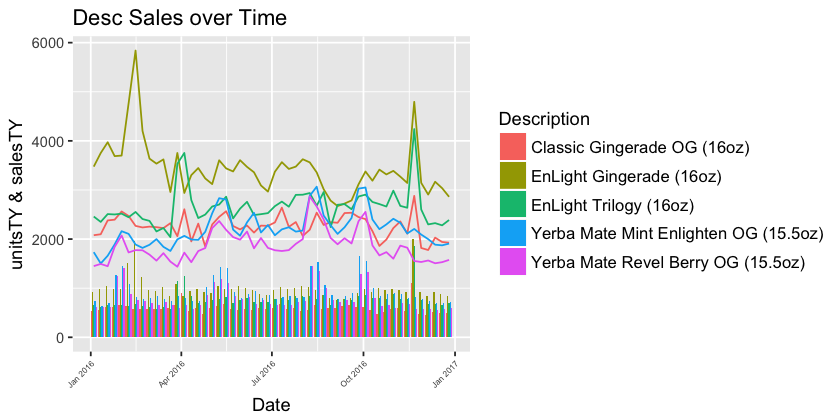

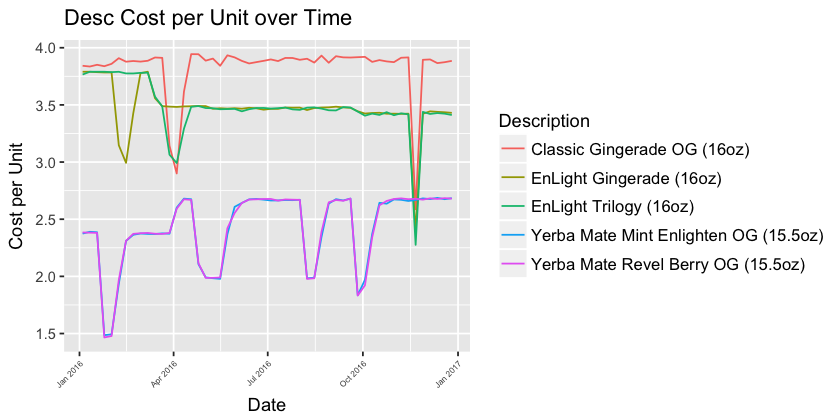

In [19]:
# plot of sales and units for top 5 products by UPC
# not currently using, used description instead
fancyplot_upc = ggplot(top_5_upc, aes(x=Date, y=unitsTY, fill=UPC)) +
    geom_bar(stat="identity", position="dodge") +
    geom_line(aes(x=Date, y=salesTY, color=UPC)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1)) +
    labs(title="UPC Sales over Time", y="unitsTY & salesTY")
# plot of cost per unit for top 5 products by UPC
# not currently using, used description instead
cpuplot_upc = ggplot(top_5_upc, aes(x=Date, y=CpU, color=UPC)) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1)) +
    labs(title="UPC Cost per Unit over Time", y="Cost per Unit")

# plot of sales and units for top 5 products by product description
fancyplot_desc = ggplot(top_5_upc, aes(x=Date, y=unitsTY, fill=Description)) +
    geom_bar(stat="identity", position="dodge") +
    geom_line(aes(x=Date, y=salesTY, color=Description)) +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.text=element_text(size=10)) +
    labs(title="Desc Sales over Time", y="unitsTY & salesTY")

# plot of cost per unit for top 5 products by product description
cpuplot_desc = ggplot(top_5_upc, aes(x=Date, y=CpU, color=Description)) +
    geom_line() +
    theme(axis.text.x = element_text(size=5, angle=45, hjust=1), legend.text=element_text(size=10)) +
    labs(title="Desc Cost per Unit over Time", y="Cost per Unit")

#fancyplot_upc
fancyplot_desc
#cpuplot_upc
cpuplot_desc

## 4. Research Questions:

1. Can I determine the benefit of a promotion based on what I set promotional price for?
2. Timing of promotions:
    * impact of co-promotion complimentary products versus just promoting one complimentary product
    * possibly identify frequency (times per year) of promoting a product
    * identify length of time to promote a product
3. Identify unintuitive complimentary products (or identify correlations that would warrent further investigation?)
4. Do product/brand names have better sales values/does using certain words increase a product's sales effectiveness?
5. Compare store location to income levels from census data to evaluate a products sales effectiveness

## 5. Project execution plan:

For the first question, I think I would use regression analysis to predict units sold based on a promotional price.  Maybe look at clustering to see correllations in complimentary products.  I am thinking when a price promotion happens, look for jumps in units sold of other products.  Could be a weak correlation, but might give us direction to look deeper.  For promotion timing analysis, I am thinking I would look at complimentary products and comare sales if only one of the products were promoted versus both, maybe assume less of a bumb in unit sales if a product wasn't on sale but more than if neither products were on sale.

Next, I would parse out words on product name and see if there are key words that correlate to higher unit sales.  This might not provide much of an insight, particularly since some products have parts of their name abbreviated in the dataset.  Nonetheless, I thought it would be worth investigating.

For the last question, I will work with census dat from assignment 1 to see if there might be some insights on sales within a zip code or state level.  Also, for starters look at income for a given zip code and see if particular products appeal more to certai income demographics.  I hadn't thought of joining census info until you mentioned it in class today, so haven't thought much on the possibility of combing the data.

## 3. Identify unintuitive complimentary products (or identify correlations that would warrant further investigation?)

In [23]:
# need control = "userid"
# looking at relative jumps in volume
#group by week anf look at week over week increase
category_units = wfm_sales_by_category %>%
    select(Category, c_rank) %>%
    inner_join(wfm_sales_date_category)# %>%
    #mutate(CpU = salesTY/unitsTY) %>%
head(category_units)

Joining, by = "Category"


Category,c_rank,Date,salesTY,unitsTY,salesLY,unitsLY
Enlightened,1,2016-01-04,15156.02,4026,14381.64,3816
Enlightened,1,2016-01-11,15219.63,4020,15843.92,4148
Enlightened,1,2016-01-18,16494.89,4347,15529.27,4071
Enlightened,1,2016-01-25,15608.66,4112,17457.60,5086
Enlightened,1,2016-02-01,16365.87,4322,19183.31,5799
Enlightened,1,2016-02-08,19212.69,5620,14277.24,3911


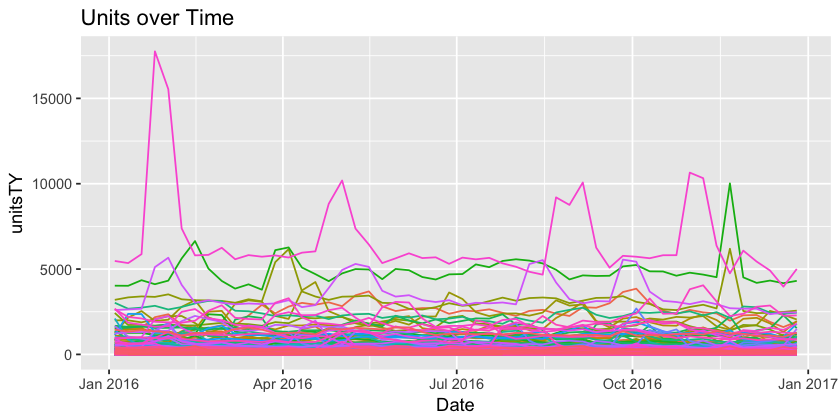

In [24]:
plot_category_units = ggplot(category_units, aes(x=Date, y=unitsTY, color=Category)) +
    geom_line(show.legend = FALSE) +
    labs(title="Units over Time", y="unitsTY")
plot_category_units

In [25]:
units_sold_cat = wfm %>%
    group_by(Category) %>%
    summarize(totalunits = sum(Units)) %>%
    arrange(-totalunits)
head(units_sold_cat)

Category,totalunits
Skyr,344729.0
Enlightened,253714.0
RTD Cans,179519.0
Classic,167822.0
20g Protein Bars,128225.0
Grains,124948.2


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”

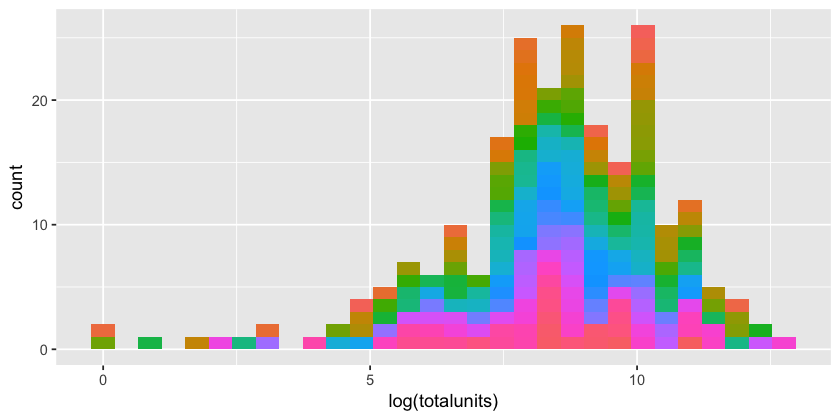

In [26]:
units_sold_plot = ggplot(units_sold_cat, aes(log(totalunits), fill=Category)) +
    geom_histogram(show.legend = FALSE)
units_sold_plot